In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import itertools
from PIL import Image
from scipy.stats import logistic


# Name of the hdf file that contain the data we need
f_name = 'sxro6416-r0504.h5'

# Open the hdf5 file, use the path to the images to extrate the data and place
# it in the image data object for further manipulation and inspection.
datafile = h5py.File(f_name, 'r')
image_data = []
for i in itertools.count(start=0):
    d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
    if d is not None:
        # actual image is at first index
        image_data.append(d[0])
    else:
        break

#print(image_data[1])
# Tell me how many images were contained in the datafile
print(f"loaded {len(image_data)} images")


#for i in range(20):
    #plt.imshow(image_data[i])
    #plt.savefig('image'+str(i)+'.png',dpi=1000)
    #image = Image.fromarray(image_data[i]).convert("L")
    #image.save("image"+str(i)+".png")

# Plot a good dataset - here index 8 (but there are others too!)
#misc.imshow(image_data[0])
#misc.show()

#image = Image.fromarray(image_data[0]).convert("L")
#image.save("out.png")

# The histogram of the data will help show possible single photon hits
plt.hist(image_data[1].flatten(), bins=100)
plt.yscale('log')


loaded 20 images


In [2]:
dat=image_data[1]
dat.shape

(2048, 2048)

In [3]:
#This is a test program. All codes will be run on this test data, extracted from image #1.
test_dat=dat[242:262,1246:1288].astype(int)-50
test_dat_2=dat[492:525,1308:1340].astype(int)-50
test_height_2=test_dat_2.shape[0]
test_width_2=test_dat_2.shape[1]
test_height=test_dat.shape[0]
test_width=test_dat.shape[1]
print(test_height,test_width)
th=test_height_2
tw=test_width_2

20 42


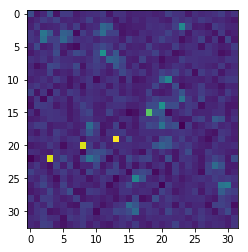

In [4]:
plt.imshow(test_dat_2)
#test_dat

In [5]:
### Define the distribution function of single photon events.

#Here, such distribution is modeled as Gaussian. Later this will be justified/replaced with more justified forms based on
#literatures and/or physical simulations

def dist_f_gaussian(x,y,x0,y0,s1,s2,A,t,cutoff=2):
    x1=(x-x0)*np.cos(t)-(y-y0)*np.sin(t)
    y1=(x-x0)*np.sin(t)+(y-y0)*np.cos(t)
    #print(x1,y1,x0,y0,s1,s2,A,t,cutoff)
    if(x1>=cutoff*s1 or y1>=cutoff*s2):
        return 0
    else:
        return A/s1/s2*np.exp(-x1**2/(2*s1**2)-y1**2/(2*s2**2))

#With respect to this distribution, we create a class of single photon events(SPE):
from scipy.integrate import simps
import math

class gaussian_spe:
    'A distribution of intensity caused by a single photon event'
    
    intensity_matrix=np.zeros((th,tw))
    
    dist_fn='gaussian'
    
    def __init__(self, y0, x0, s1, s2, A, t=0, cutoff=2):
        self.x0 = x0
        self.y0 = y0
        self.s1 = s1
        self.s2 = s2
        self.A = A
        self.t = t
        self.cutoff = cutoff
        test_height=th
        test_width=tw
        self.intensity_matrix=np.zeros((test_height,test_width))
        s=max([s1,s2])+0.5
        for i in range(test_height):
            for j in range(test_width):
                
                if(not((i<x0+cutoff*s and i>x0-cutoff*s) and (j<y0+cutoff*s and j>y0-cutoff*s))):
                    continue
                """
                #The simpson rule method
                
                x=np.linspace(i,i+1,sample_length)
                y=np.linspace(j,j+1,sample_length)
                #zz = self.dist(x.reshape(-1,1),y.reshape(1,-1))
                zz=np.zeros((sample_length,sample_length))
                for xi in range(sample_length):
                    for yi in range(sample_length):
                        zz[xi,yi]=self.dist(x[xi],y[yi])
                dist=lambda x,y: self.dist(x,y)
                #self.intensity_matrix[i,j]=integrate.dblquad(dist,i,i+1,lambda x:j,lambda x:j+1,epsabs=1e-4, epsrel=1e-4)[0]
                self.intensity_matrix[i,j]=simps([simps(zz_x,x) for zz_x in zz],y) 
                """
                
                #The MUCH SIMPLER erf method
                
                self.intensity_matrix[i,j]=1/2*np.pi*self.A*(math.erf((-self.x0+i)/math.sqrt(2)/s1)-math.erf((-self.x0+i+1)/math.sqrt(2)/s1))*(math.erf((-self.y0+j)/math.sqrt(2)/s2)-math.erf((-self.y0+j+1)/math.sqrt(2)/s2))
                
    
    def dist(self,x,y):
        return dist_f_gaussian(x,y,self.x0,self.y0,self.s1,self.s2,self.A,self.t,self.cutoff)
    
    def new_value(self, y0, x0, s1, s2, A, t=0, cutoff=2):
        self.x0 = x0
        self.y0 = y0
        self.s1 = s1
        self.s2 = s2
        self.A = A
        self.t = t
        self.cutoff = cutoff
        s=max([s1,s2])+1.5
        for i in range(test_height):
            for j in range(test_width):
                if(not((i<x0+cutoff*s and i>x0-cutoff*s) and (j<y0+cutoff*s and j>y0-cutoff*s))):
                    continue
                x=np.linspace(i,i+1,sample_length)
                y=np.linspace(j,j+1,sample_length)
                #zz = self.dist(x.reshape(-1,1),y.reshape(1,-1))
                zz=np.zeros((sample_length,sample_length))
                for xi in range(sample_length):
                    for yi in range(sample_length):
                        zz[xi,yi]=self.dist(x[xi],y[yi])
                dist=lambda x,y: self.dist(x,y)
                #self.intensity_matrix[i,j]=integrate.dblquad(dist,i,i+1,lambda x:j,lambda x:j+1,epsabs=1e-4, epsrel=1e-4)[0]
                self.intensity_matrix[i,j]=simps([simps(zz_x,x) for zz_x in zz],y) 
    
    def copy(self):
        return self
                
from scipy import integrate
import time

# The error function. It is defined as ...; the minimisation of which is the ultimate goal of this part of the code. 
def error(spe__array,dat_tag,input_dat=test_dat):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

def error(spe__array, input_dat=test_dat):
    matrix=input_dat
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[i,j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

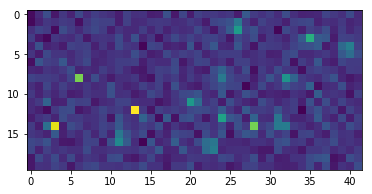

In [6]:
plt.imshow(test_dat)

In [7]:
class tag:
    'used to tag SPEs.'
    lx=0
    ly=0
    rx=0
    ry=0
    width=0
    height=0
    
    def __init__(self,lx,ly,rx,ry):
        self.lx=lx
        self.ly=ly
        self.rx=rx
        self.ry=ry
        self.width=rx-lx
        self.height=ry-ly
    
    def param(self):
        return [self.lx,self.ly,self.rx,self.ry]
    
    def hw(self):
        return [self.height,self.width]
    
def thresholding(dataset,threshold):
    label_matrix=np.zeros(dataset.shape)
    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            if(dataset[i,j]>=threshold):
                label_matrix[i,j]=1
    return label_matrix
    
from copy import deepcopy
    
def boxing(thres_matrix):
    lm=deepcopy(thres_matrix);

    def search(x,y):
        lefttop_x=x-1
        lefttop_y=y-1
        rightbot_x=x+1
        rightbot_y=y+1
        if(lm[x,y]==0):
            return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
        else:
            lm[x,y]=0
        for i in [x-2,x-1,x,x+1,x+2]:
            for j in [y-2,y-1,y,y+1,y+2]:
                if((i>=lm.shape[0]) or (j>=lm.shape[1])):
                    continue
                elif(lm[i,j]==1):
                    [a,b,c,d]=search(i,j)
                    #print([a,b,c,d])
                    lm[i,j]=0
                    lefttop_x=min([lefttop_x,a])
                    lefttop_y=min([lefttop_y,b])
                    rightbot_x=max([rightbot_x,c])
                    rightbot_y=max([rightbot_y,d])
                    #print('a',[lefttop_x,lefttop_y,rightbot_x,rightbot_y])
       
        return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
    #[lx,ly,rx,ry]=search(17,20,lm)
    #thres_matrix[lx,ly]=2
    #thres_matrix[rx,ry]=2
    #plt.imshow(thres_matrix)
    
    
    tag_list=[]
    
    flag=0

    while(True):
        for i in range(thres_matrix.shape[0]):
            for j in range(thres_matrix.shape[1]):
                if(lm[i,j]==1):
                    flag=1
                    [lx,ly,rx,ry]=search(i,j)
                    thres_matrix[lx,ly]=2
                    thres_matrix[rx,ry]=2
                    t=tag(lx,ly,rx,ry)
                    tag_list.append(t)
                    break
            if(flag==1):
                break
        if(flag==0):
            break
        flag=0
    return tag_list



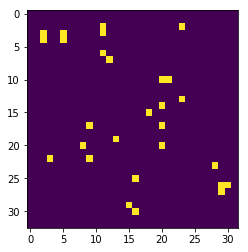

In [8]:
l2=thresholding(test_dat_2,30)
l1=thresholding(test_dat,30)

l2l=thresholding(test_dat_2,60)

tag_list=boxing(deepcopy(l2))

plt.imshow(l2)

In [29]:
import random

smin=0.2
smax=0.5

Amin=50
Amax=250

tmin=0
tmax=np.pi

def error(spe__array,dat_tag,input_dat=test_dat):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                #print(event.intensity_matrix.shape)
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

#sample_length=40

def gradient_descent_single(input_dat,dat_tag,output='verbose'):
    l=dat_tag.param()[0]
    r=dat_tag.param()[2]+1
    t=dat_tag.param()[1]
    b=dat_tag.param()[3]+1
    dat=input_dat[l:r,t:b]
    #return dat
    #print(dat)
    [i0,i1]=np.unravel_index(dat.argmax(),dat.shape)
    
    #return index
    xavg=0
    yavg=0
    for i in range(dat.shape[0]):
        for j in range(dat.shape[1]):
            xavg=xavg+i*dat[i,j]
            yavg=yavg+j*dat[i,j]
    
    x=l+xavg/sum(dat.flatten())+0.5
    y=t+yavg/sum(dat.flatten())+0.5
    
    #x=l+i0+0.5
    #y=t+i1+0.5
    
    if(output=='verbose'):
        print(x,y)    
        print(dat)
    
    #s_x=random.uniform(smin,smax)
    #s_y=random.uniform(smin,smax)
    #A=random.uniform(Amin,Amax)
    
    s_x=0.25+0.25*(dat[i0+1,i1]+dat[i0-1,i1])/dat[i0,i1]
    s_y=0.25+0.25*(dat[i0,i1+1]+dat[i0,i1-1])/dat[i0,i1]
    
    #s_x=0.4
    #s_y=0.4
    #A=dat.max()
    A=15
    
    spe=gaussian_spe(y,x,s_x,s_y,A)
    #print([x,y,s_x,s_y,A])
    #print(l,r,t,b)
    if(output=='verbose'):
        print(spe.intensity_matrix[l:r,t:b].astype(int))
    
    
    err=error([spe],dat_tag,input_dat)
    #print(err)
    
    step_xy=0.01
    step_s=0.005
    step_A=0.3
    descent_factor=0.05
    
    err_array=[]
    
    #print([x,y,s_x,s_y,A])
    
    for i in range(100):
        err=error([spe],dat_tag,input_dat)
        p_x=error([gaussian_spe(y,x+step_xy,s_x,s_y,A)],dat_tag,input_dat)-err
        p_y=error([gaussian_spe(y+step_xy,x,s_x,s_y,A)],dat_tag,input_dat)-err
        p_sx=error([gaussian_spe(y,x,s_x+step_s,s_y,A)],dat_tag,input_dat)-err
        p_sy=error([gaussian_spe(y,x,s_x,s_y+step_s,A)],dat_tag,input_dat)-err
        p_A=error([gaussian_spe(y,x,s_x,s_y,A+step_A)],dat_tag,input_dat)-err
        x=x-p_x*descent_factor*step_xy
        y=y-p_y*descent_factor*step_xy
        s_x=s_x-p_sx*descent_factor*step_s
        s_y=s_y-p_sy*descent_factor*step_s
        A=A-p_A*descent_factor*step_A
        spe=gaussian_spe(y,x,s_x,s_y,A)
        err_array.append(err)
        
        if(s_x<smin):
            s_x=smin
        if(s_y<smin):
            s_y=smin
        
        if(i>=11 and np.abs(err-err_array[i-11])<=err/40):
            if(err>len(dat.flatten())*100):
                print('suspicious case')
            if(output=='verbose'):
                print(err,err_array[i-11])
            break
        
        
        if(output=='verbose'):
            print([x,y,s_x,s_y,A])
        #if(err<=200):
            #print('target reached')
            #break
    if(output=='verbose'):
        plt.plot(err_array)

    print(spe.intensity_matrix[l:r,t:b].astype(int))
    print(err)
    if(err>2000):
        print('suspicious case')

th=test_height_2
tw=test_width_2

22.5234375 3.75
[[ -6  -8   4]
 [ -2 144   3]
 [ -5 -14  12]]
[[ 0  0  0]
 [ 0 77 14]
 [ 0  0  0]]
[22.518076555638277, 3.679100040482353, 0.20355861203465192, 0.23356575921725564, 17.942328443023122]
[22.513951317324874, 3.6426283832204294, 0.2, 0.2201830153751338, 20.026100396562217]
[22.50567117943543, 3.6193284196591264, 0.2, 0.2095127063879188, 21.209213221651414]
[22.49394531895385, 3.6009408578575623, 0.2, 0.2001868858393047, 21.795686608186944]
[22.48400075400244, 3.5881546886920384, 0.2, 0.2, 22.149801065004844]
[22.472622384672253, 3.575023613536542, 0.2, 0.2, 22.311665372440277]
[22.46282023309075, 3.5639470282986276, 0.2, 0.2, 22.44016839363384]
[22.455372343679368, 3.5555137504111527, 0.2, 0.2, 22.579591711162124]
[22.450045891571133, 3.5494567011759965, 0.2, 0.2, 22.727869911667277]
[22.446334176938834, 3.545268838713444, 0.2, 0.2, 22.872540231796602]
[22.443732480629937, 3.5424377100769, 0.2, 0.2, 23.00287585887051]
[22.44183486034294, 3.5405341778106365, 0.2, 0.2, 23.11

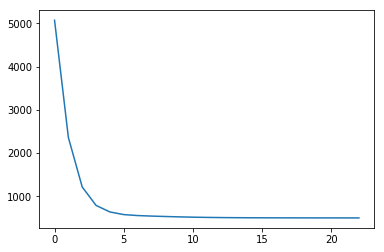

In [30]:
start=time.time()

gradient_descent_single(test_dat_2,tag_list[12],'verbose')
end=time.time()
print(end-start)

In [17]:
th=test_height
tw=test_width
tag_list_1=boxing(deepcopy(l1))

tag_list_1[1].param()

[2, 34, 4, 36]

In [14]:
gradient_descent_single(test_dat,tag_list_1[1],'verbose')


NameError: name 'tag_list_1' is not defined

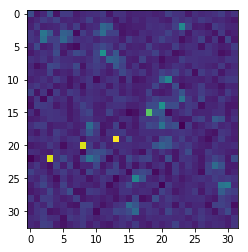

In [24]:
plt.imshow(test_dat_2)